In [41]:
!jupyter notebook

|INFO|google.colab serverextension initialized.
|INFO|Serving notebooks from local directory: /content/sample_data
|INFO|0 active kernels
|INFO|The Jupyter Notebook is running at:
|INFO|http://localhost:8888/
|INFO|Use Control-C to stop this server and shut down all kernels (twice to skip confirmation).
|CRITICAL|received signal 2, stopping
|INFO|Shutting down 0 kernels


In [40]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [45]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
print(float_data.shape)
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

(420551, 14)


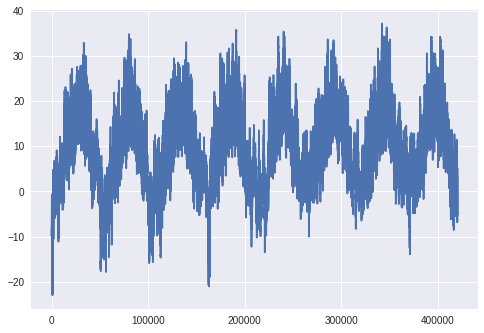

In [47]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

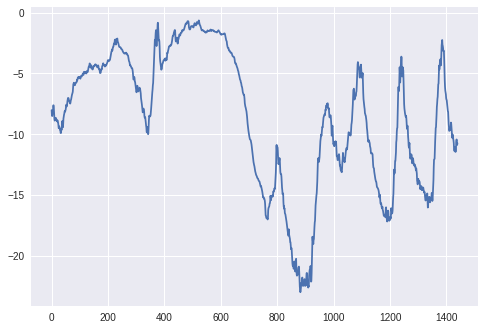

In [48]:
plt.plot(range(1440), temp[:1440])

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen =  generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)